# Nonlinearity

Nonlinear functions are functions whose output is not proportional to its input. In this notebook, we visualize the effects of these nonlinearities on neural networks by plotting the decision surface of a model with nonlinearities and another one without them. For a more detailed review of neural networks and nonlinear functions, see `neuralnetworks.ipynb`. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from matplotlib_inline.backend_inline import set_matplotlib_formats
from sklearn import datasets
from torch import nn

set_matplotlib_formats("retina")

We use Scikit-learn's `make_moons` function to generate an artificial dataset. The resulting "moons" dataset consists of two interleaving half-circles, each representing a different class.

In [2]:
moons = datasets.make_moons(n_samples=400, noise=0.3, random_state=1)
X, y = moons

print(X.shape, y.shape)
print(X[0], y[0])

(400, 2) (400,)
[2.14226354 0.33884485] 1


In [3]:
X.min(axis=0), X.max(axis=0)

(array([-1.45931782, -1.12877465]), array([2.41185861, 1.96473485]))

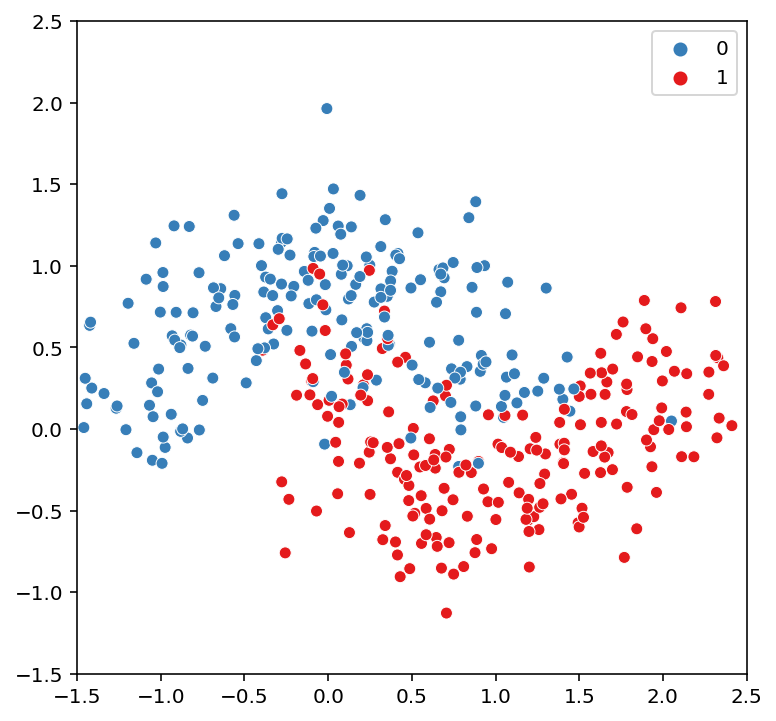

In [4]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=["#377eb8", "#e41a1c"])
ax.set_xlim((-1.5, 2.5))
ax.set_ylim((-1.5, 2.5))
plt.show()

Since we use PyTorch as our deep learning backend, we convert the dataset to `torch` tensors.

In [5]:
inputs = torch.tensor(X, dtype=torch.float)
labels = torch.tensor(np.expand_dims(y, axis=1), dtype=torch.float)

inputs.shape

torch.Size([400, 2])

To learn to classify the samples in the moons dataset, we train a neural network with two hidden layers. Each layer consists of 10 neurons (units). The model has a total of 151 trainable parameters. As activation function, we use ReLU for the hidden layers, and Sigmoid for the output layer.

In [6]:
class NeuralNetwork(nn.Module):

    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

torch.manual_seed(2022)
model = NeuralNetwork().to("cpu")

Since the task at hand is a binary classification problem, we use binary cross-entropy as the loss function. The model is then trained for 10000 epochs in full-batches using the Adam optimizer.

In [7]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
losses = []
epochs = 10000

# Training loop
for epoch in range(epochs):
    # Forward pass
    pred = model.forward(inputs)
    loss = loss_fn(pred, labels)
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    if epoch % 2000 == 0:
        print(f"loss: {loss:7f} [{epoch:>5d}/{epochs}]")

loss: 0.709905 [    0/10000]
loss: 0.287656 [ 2000/10000]
loss: 0.227615 [ 4000/10000]
loss: 0.218875 [ 6000/10000]
loss: 0.213631 [ 8000/10000]


In [8]:
losses[-1]

0.20405817031860352

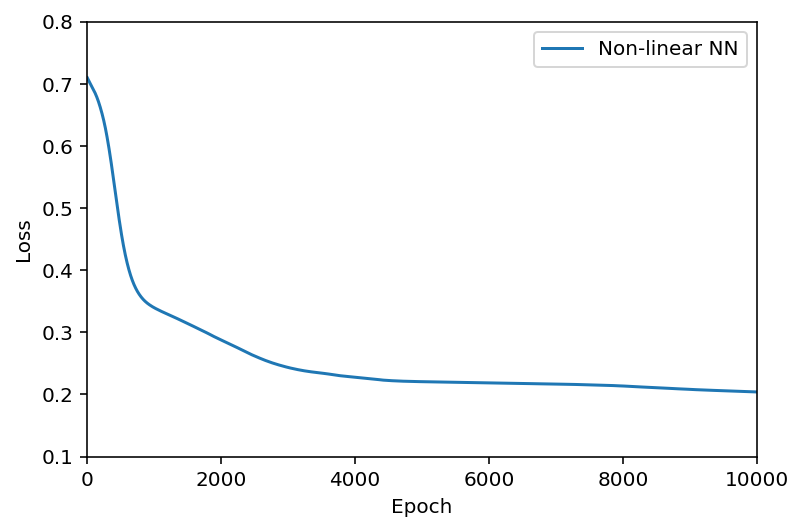

In [9]:
plt.plot(losses, label="Non-linear NN")
plt.xlim(xmin=0, xmax=epochs)
plt.ylim(ymin=0.1, ymax=0.8)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The model achieves ***91.25% accuracy*** on the training dataset.

In [10]:
preds = model.forward(inputs)
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0
torch.sum(preds == labels) / 400

tensor(0.9125)


Finally, we plot the decision surface of the model.

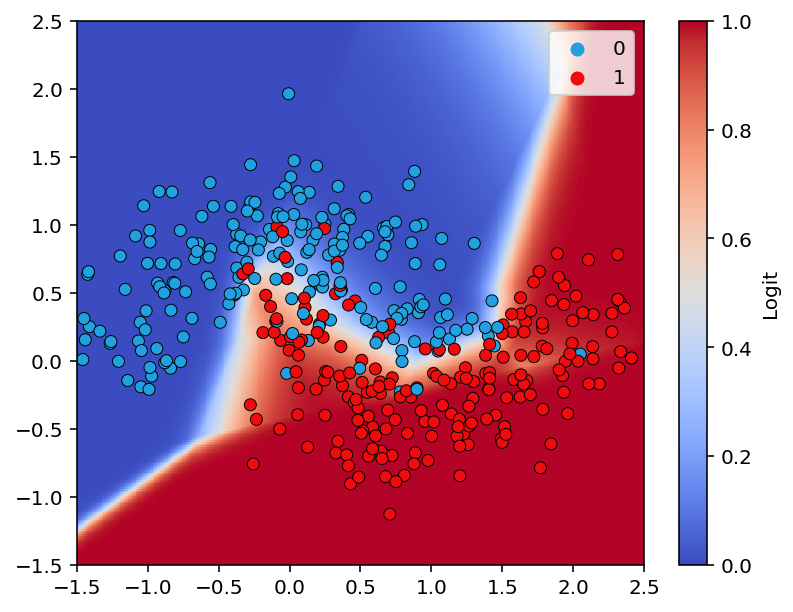

In [12]:
i = torch.linspace(-1.5, 2.5, 300)
grid_x, grid_y = torch.meshgrid(i, i)
z = model.forward(torch.cat((grid_y.unsqueeze(2), grid_x.unsqueeze(2)), 2)).detach()

fig, ax = plt.subplots(figsize=(6.35, 5))
im = ax.imshow(z, cmap="coolwarm", interpolation="nearest", origin="lower", aspect="auto", extent=[-1.5, 2.5, -1.5, 2.5])
m = plt.cm.ScalarMappable(cmap="coolwarm")
m.set_clim(0., 1.)
cb = fig.colorbar(m, ax=ax)
cb.set_label("Logit")
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=["#22a1e0", "#f00c0e"], lw=0.5, ec="k")
plt.savefig("assets/moons_logits.png", dpi=200, bbox_inches='tight')
plt.show()

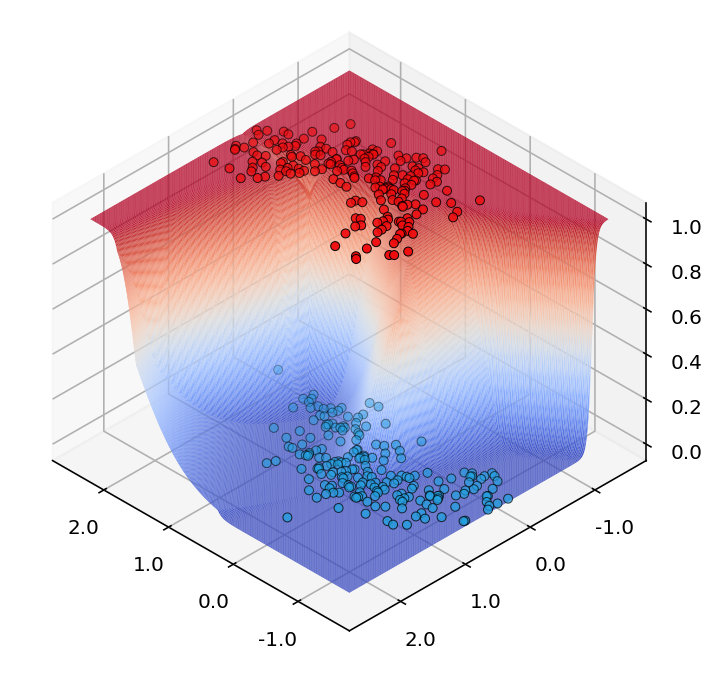

In [13]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
c = ["#f00c0e" if v == 1 else "#22a1e0" for v in y]
ax.scatter(X[:, 0], X[:, 1], y, c=c, lw=0.5, ec="k")
ax.plot_surface(grid_y, grid_x, z.squeeze(axis=2), lw=0, alpha=0.99, rstride=1, cstride=1, cmap="coolwarm", antialiased=True)
ax.view_init(azim=135, elev=35)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.set_proj_type('ortho')
plt.savefig("assets/moons_logits_3d.png", dpi=200, bbox_inches='tight')
plt.show()

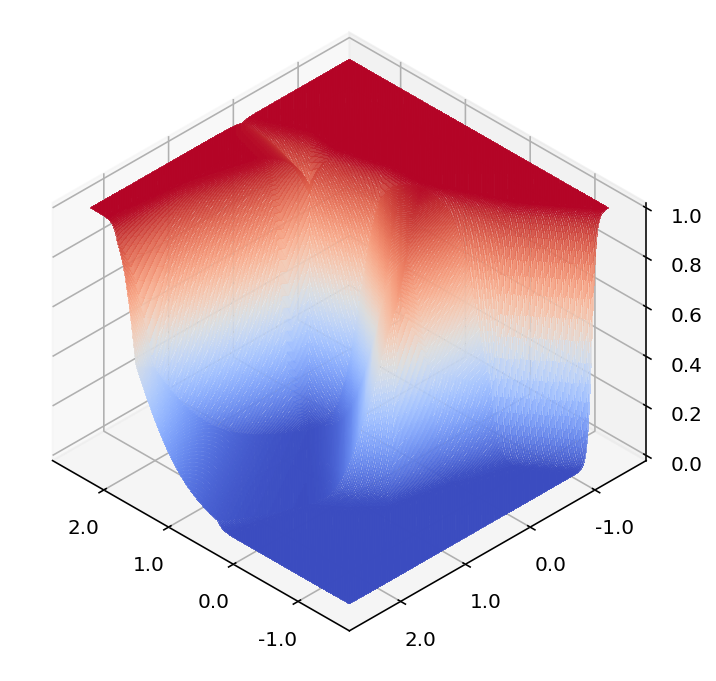

In [14]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(grid_y, grid_x, z.squeeze(axis=2), lw=0, alpha=0.7, rstride=1, cstride=1, cmap="coolwarm", antialiased=False)
ax.view_init(azim=135, elev=35)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.set_proj_type('ortho')
plt.savefig("assets/moons_logits_3d.png", dpi=200, bbox_inches='tight')
plt.show()

The linear model has the same structure as the non-linear one, but includes no ReLU and Sigmoid activation functions.

In [15]:
class LinearNeuralNetwork(nn.Module):

    def __init__(self):
        super(LinearNeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 10),
            nn.Linear(10, 10),
            nn.Linear(10, 1),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

torch.manual_seed(2022)
model = LinearNeuralNetwork().to("cpu")

Since the output of the linear model is not bounded to a range $(0, 1)$, we frame the classification task as a real-value label prediction problem, and quantify the loss using the mean standard error. The model is trained for 10000 epochs with the Adam optimizer.

In [16]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
losses = []
epochs = 10000

# Training loop
for epoch in range(epochs):
    # Forward pass
    pred = model.forward(inputs)
    loss = loss_fn(pred, labels)
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    if epoch % 2000 == 0:
        print(f"loss: {loss:7f} [{epoch:>5d}/{epochs}]")

loss: 0.441687 [    0/10000]
loss: 0.111607 [ 2000/10000]
loss: 0.111607 [ 4000/10000]
loss: 0.111607 [ 6000/10000]
loss: 0.111607 [ 8000/10000]


In [17]:
losses[-1]

0.11160686612129211

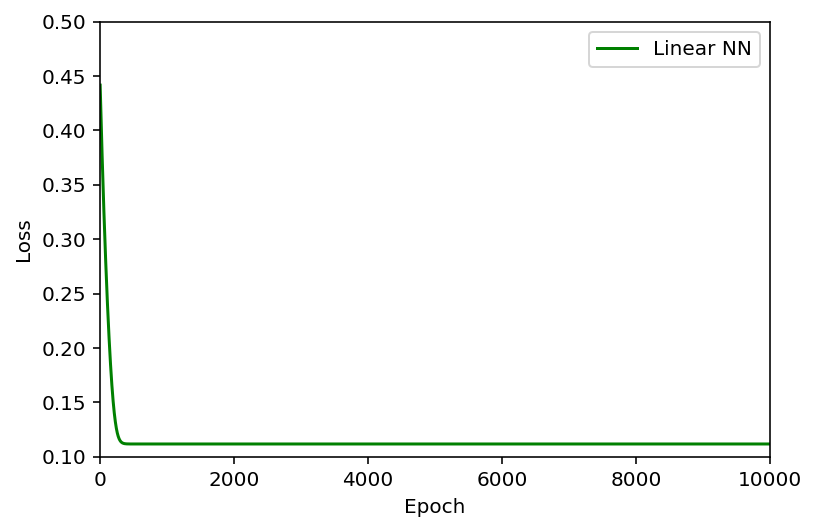

In [18]:
plt.plot(losses, color="g", label="Linear NN")
plt.xlim(xmin=0, xmax=epochs)
plt.ylim(ymin=0.1, ymax=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The model achieves ***83.25% accuracy*** on the training data, 8% lower than the nonlinear model.

In [19]:
preds = model.forward(inputs)
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0
torch.sum(preds == labels) / 400

tensor(0.8325)

As expected, the decision surface of the model without nonlinearities is linear.

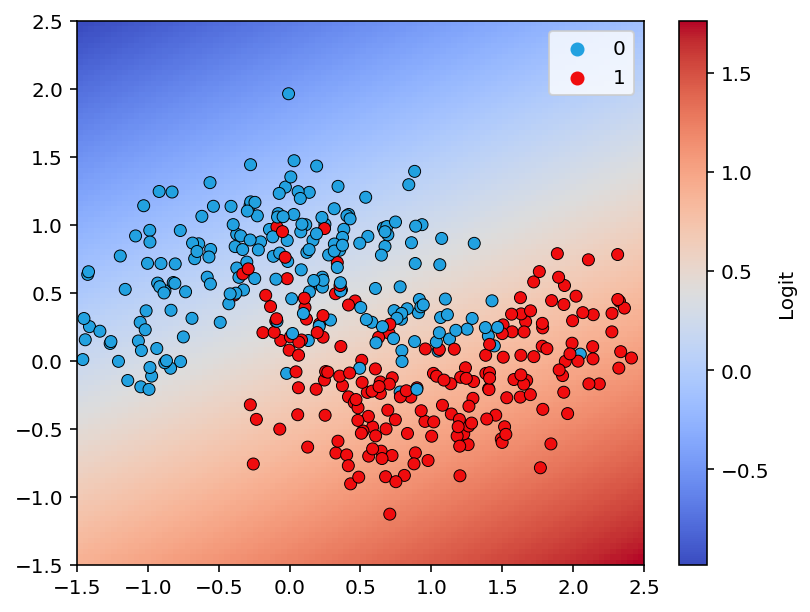

In [20]:
i = torch.linspace(-1.5, 2.5, 100)
grid_x, grid_y = torch.meshgrid(i, i)
z = model.forward(torch.cat((grid_y.unsqueeze(2), grid_x.unsqueeze(2)), 2)).detach()

fig, ax = plt.subplots(figsize=(6.35, 5))
im = ax.imshow(z, cmap="coolwarm", interpolation="nearest", origin="lower", aspect="auto", extent=[-1.5, 2.5, -1.5, 2.5])
m = plt.cm.ScalarMappable(cmap="coolwarm")
m.set_clim(-0.98, 1.76)
cb = fig.colorbar(m, ax=ax)
cb.set_label("Logit")
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=["#22a1e0", "#f00c0e"], lw=0.5, ec="k")
plt.savefig("assets/moons_linear.png", dpi=200, bbox_inches='tight')
plt.show()

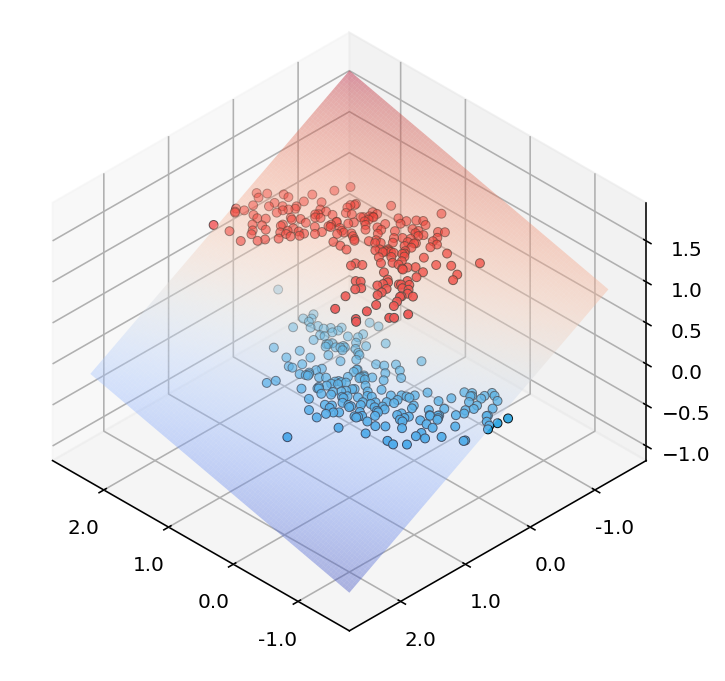

In [21]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(grid_y, grid_x, z.squeeze(axis=2), lw=1, alpha=0.4, rstride=1, cstride=1, cmap="coolwarm", antialiased=True)
ax.view_init(azim=135, elev=35)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.set_proj_type('ortho')
c = ["#f00c0e" if v == 1 else "#22a1e0" for v in y]
ax.scatter(X[:, 0], X[:, 1], y, c=c, lw=0.5, ec="k")
plt.savefig("assets/moons_linear_3d.png", dpi=200, bbox_inches='tight')
plt.show()

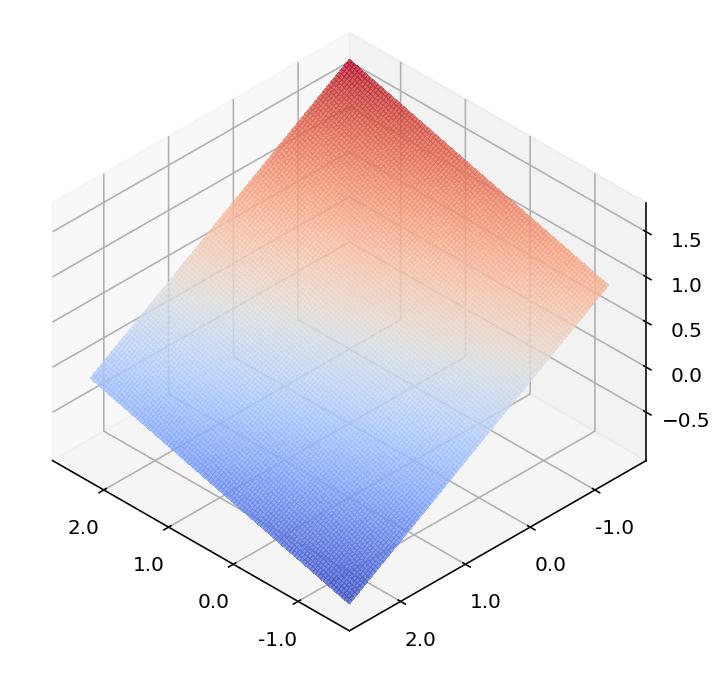

In [22]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(grid_y, grid_x, z.squeeze(axis=2), lw=0, alpha=0.7, rstride=1, cstride=1, cmap="coolwarm", antialiased=False)
ax.view_init(azim=135, elev=35)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.set_proj_type('ortho')
plt.savefig("assets/moons_linear_3d.png", dpi=200, bbox_inches='tight')
plt.show()